## Understanding the data

In [220]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


In [136]:
df_calendar = pd.read_csv('./calendar.csv')
print(df_calendar.shape)
df_calendar.head()

(1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


We should transform the price to numeric and available to 0 and 1s. It may also be useful to extend the date to year, month and day.

In [137]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [138]:
df_listings = pd.read_csv('./listings.csv')
print(df_listings.shape)
df_listings.review_scores_rating.count()

(3818, 92)


3171

In [139]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

<AxesSubplot:>

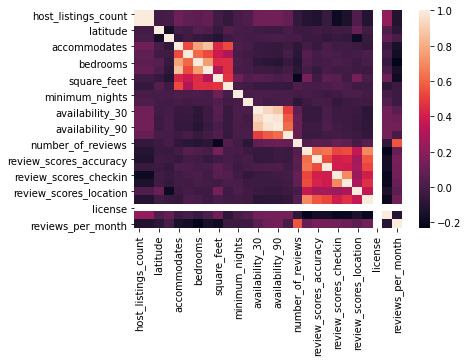

In [140]:
sns.heatmap(df_listings.drop(['id', 'host_id', 'scrape_id'], axis=1).corr())

There are a lot of variables, we might have a look whether we could drop columns with a lot of NAs or other columns that are just not useful. We also might transform some of the objects to ints (prices, fees).

In [141]:
df_reviews = pd.read_csv('./reviews.csv')
print(df_reviews.shape)
df_reviews.head()

(84849, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [142]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


not a lot to do, only comments has a few missing entries.

## Cleaning and Preparing the data

### starting with df_calendar

In [143]:
# transform variable available
df_calendar['available'].replace(['t', 'f'], [1,0], inplace = True)
df_calendar['available'].value_counts()

1    934542
0    459028
Name: available, dtype: int64

In [144]:
# extract year, month and day (not necassary for the question, but probably useful for further analysis)
df_calendar['year'] = pd.DatetimeIndex(df_calendar['date']).year
df_calendar['month'] = pd.DatetimeIndex(df_calendar['date']).month
df_calendar['day'] = pd.DatetimeIndex(df_calendar['date']).day

In [145]:
# convert price to float
df_calendar['price'] = pd.to_numeric(df_calendar['price'].str.replace('\W', ''))/100



In [146]:
# fill NAs: mean does not make sence, not filled prices should be the same as the entry before -> ffill method
df_calendar['price'] = df_calendar['price'].fillna(method='ffill')

In [147]:
df_calendar.head()

,listing_id,date,available,price,year,month,day
0,241032,2016-01-04,1,85.0,2016,1,4
1,241032,2016-01-05,1,85.0,2016,1,5
2,241032,2016-01-06,0,85.0,2016,1,6
3,241032,2016-01-07,0,85.0,2016,1,7
4,241032,2016-01-08,0,85.0,2016,1,8


### main work: df_listings

In [148]:
df_listings.isna().sum().sort_values(ascending=False)

license             3818
square_feet         3721
monthly_price       2301
security_deposit    1952
weekly_price        1809
                    ... 
accommodates           0
bed_type               0
amenities              0
price                  0
id                     0
Length: 92, dtype: int64

There are some columns where most of the entries are missing. For none of the top ones there is a good practice to fill NAs. Let's see for which columns at least 50% of the data is missing.

In [149]:
# remove these columns
missing_columns = df_listings.columns[df_listings.isna().mean()>0.5]
df_listings = df_listings.drop(columns = missing_columns)

In [150]:
df_listings.shape

(3818, 88)

Are there any other columns of type object which should be float? Seems like host_response_rate, host_acceptance_rate, host_is_superhost, price and cleaning fee are candidates.

In [151]:
df_listings.select_dtypes(['object']).columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'cleaning_fee', 'extra_people', 'calendar_updated',
       'has_availability', 'calendar_last_scraped', 'first_review',
       'last_review

In [152]:
# starting with the price and there are no missing values
df_listings.price = pd.to_numeric(df_listings.price.str.replace('\W', ''))/100
print(df_listings.price.isnull().sum())


0


In [153]:
# response rate, acceptance rate, is superhost, cleaning fee 
df_listings.host_response_rate = pd.to_numeric(df_listings.host_response_rate.str.replace('\W', ''))/100
df_listings.host_acceptance_rate = pd.to_numeric(df_listings.host_acceptance_rate.str.replace('\W', ''))/100
df_listings.host_is_superhost.replace(['t', 'f'], [1,0], inplace = True)
df_listings.cleaning_fee = pd.to_numeric(df_listings.cleaning_fee.str.replace('\W', ''))/100

In [154]:
# for superhost it makes sense to replace the missing values with 0, for all others, all others can be filled with the mean
df_listings.host_is_superhost = df_listings.host_is_superhost.fillna(0)
df_listings.host_is_superhost.isnull().sum()


0

There might also be some categorical variables which we should transform to dummies. Property type and bed type have many different values and there are a lot values not ocurring very often, so let's try with room type. 

In [155]:
# get dummy variables for room_type and replace the columns in the dataset
room_dummies = pd.get_dummies(df_listings.room_type)
df_listings = df_listings.drop(['room_type'], axis=1)
df_listings = pd.concat([df_listings, room_dummies], axis=1)
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Entire home/apt,Private room,Shared room
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,WASHINGTON,f,moderate,f,f,2,4.07,1,0,0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,WASHINGTON,f,strict,t,t,6,1.48,1,0,0
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,WASHINGTON,f,strict,f,f,2,1.15,1,0,0
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,WASHINGTON,f,flexible,f,f,1,NaN,1,0,0
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,WASHINGTON,f,strict,f,f,1,0.89,1,0,0


In the next step we fill the missing values in object type columns with the mode and in numeric columns with the mean and receive a data set we can work with.

In [156]:
# starting with numeric type columns 
numeric_cols = df_listings.select_dtypes(['float64', 'int64']).columns

# for numeric columns replace NAs with the mean of the column
for i in numeric_cols:
    df_listings[i].fillna(df_listings[i].mean(), inplace = True)

# have a look at the data whether it worked
print(df_listings.select_dtypes(['float64', 'int64']).head().isna().sum())
df_listings.select_dtypes(['float64', 'int64']).head()

id                                0
scrape_id                         0
host_id                           0
host_response_rate                0
host_acceptance_rate              0
host_is_superhost                 0
host_listings_count               0
host_total_listings_count         0
latitude                          0
longitude                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
price                             0
cleaning_fee                      0
guests_included                   0
minimum_nights                    0
maximum_nights                    0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin       

,id,scrape_id,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,latitude,longitude,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
0,241032,20160104002432,956883,0.960000,1.000000,0.0,3.0,3.0,47.636289,-122.371025,...,207,95.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,2,4.070000
1,953595,20160104002432,5177328,0.980000,1.000000,1.0,6.0,6.0,47.639123,-122.365666,...,43,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6,1.480000
2,3308979,20160104002432,16708587,0.670000,1.000000,0.0,2.0,2.0,47.629724,-122.369483,...,20,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2,1.150000
3,7421966,20160104002432,9851441,0.948868,0.999672,0.0,1.0,1.0,47.638473,-122.369279,...,0,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,1,2.078919
4,278830,20160104002432,1452570,1.000000,0.999672,0.0,2.0,2.0,47.632918,-122.372471,...,38,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1,0.890000


In [157]:
# for object type columns: replace NAs with the mode of the column like we did for numeric columns with the mean
obj_cols = df_listings.select_dtypes(['object']).columns

# for numeric columns replace NAs with the mean of the column
for i in obj_cols:
    df_listings[i].fillna(df_listings[i].mode()[0], inplace = True)

# have a look at the data whether it worked
print(df_listings.select_dtypes(['object']).head().isna().sum())
df_listings.select_dtypes(['object']).head()

listing_url                         0
last_scraped                        0
name                                0
summary                             0
space                               0
description                         0
experiences_offered                 0
neighborhood_overview               0
notes                               0
transit                             0
thumbnail_url                       0
medium_url                          0
picture_url                         0
xl_picture_url                      0
host_url                            0
host_name                           0
host_since                          0
host_location                       0
host_about                          0
host_response_time                  0
host_thumbnail_url                  0
host_picture_url                    0
host_neighbourhood                  0
host_verifications                  0
host_has_profile_pic                0
host_identity_verified              0
street      

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,has_availability,calendar_last_scraped,first_review,last_review,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,https://www.airbnb.com/rooms/241032,2016-01-04,Stylish Queen Anne Apartment,This is a modern fully-furnished studio apartm...,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,Wallingford is a mostly-residential neighborho...,All of our rentals are fully licensed and regu...,Convenient public transportation. The location...,...,t,2016-01-04,2011-11-01,2016-01-02,f,WASHINGTON,f,moderate,f,f
1,https://www.airbnb.com/rooms/953595,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",...,t,2016-01-04,2013-08-19,2015-12-29,f,WASHINGTON,f,strict,t,t
2,https://www.airbnb.com/rooms/3308979,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,...,t,2016-01-04,2014-07-30,2015-09-03,f,WASHINGTON,f,strict,f,f
3,https://www.airbnb.com/rooms/7421966,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,"*Note: This fall, there will be major renovati...",A charming apartment that sits atop Queen Anne...,none,Wallingford is a mostly-residential neighborho...,All of our rentals are fully licensed and regu...,Convenient public transportation. The location...,...,t,2016-01-04,2015-09-21,2016-01-02,f,WASHINGTON,f,flexible,f,f
4,https://www.airbnb.com/rooms/278830,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,...,t,2016-01-04,2012-07-10,2015-10-24,f,WASHINGTON,f,strict,f,f


In [160]:
# check whether we forgot something
sum(df_listings.isnull().sum()>0)

0

### part 3: df_reviews

In [165]:
# date should be a datetime
df_reviews['date'] = pd.to_datetime(df_reviews.date)

In [168]:
# only missing values in the comments column. For this purpose it is ok to replace the missing comments just with the comment missing
print(df_reviews.isnull().sum())
df_reviews.comments.fillna('missing', inplace=True)

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64


In [169]:
df_reviews.isnull().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

Now we have clean datasets and are ready to start with our questions

## Question 1: Which neighbourhood are most popular?

We want to know the rate of availability for each neigbourhood. Therefore we calculate this rate first for each home and then the mean and median for each neighbourhood. We will restrict to neighbourhoods with at least 50 homes.

In [192]:
# calculate availability of every home
availability = pd.DataFrame(df_calendar[['listing_id', 'available']].groupby('listing_id').mean())

# merge with neighbourhood data
neighbourhood = availability.merge(df_listings[['id', 'neighbourhood']], left_index = True, right_on = 'id')
neighbourhood.head()

,available,id,neighbourhood
2184,0.846575,3335,Dunlap
3118,1.000000,4291,Roosevelt
2166,0.846575,5682,South Delridge
377,1.000000,6606,Wallingford
2757,0.145205,7369,Broadway


In [199]:
# final step: calculate the average availability rate for neighbourhoods, also add counts, 
# since later we only consider those with at least 50 homes
neighbourhood_final = pd.DataFrame(neighbourhood.groupby('neighbourhood').available.mean())
neighbourhood_final['count'] = neighbourhood.groupby('neighbourhood').id.count()
neighbourhood_final['booked'] = 1-neighbourhood_final['available']
neighbourhood_final.head()

,available,count,booked
neighbourhood,,,
Alki,0.685884,23,0.314116
Arbor Heights,0.712329,3,0.287671
Atlantic,0.599781,50,0.400219
Ballard,0.687144,213,0.312856
Belltown,0.616344,204,0.383656


In [294]:
pd.DataFrame(neighbourhood_final[neighbourhood_final['count']>50].booked.sort_values(ascending=False)).shape

(19, 1)

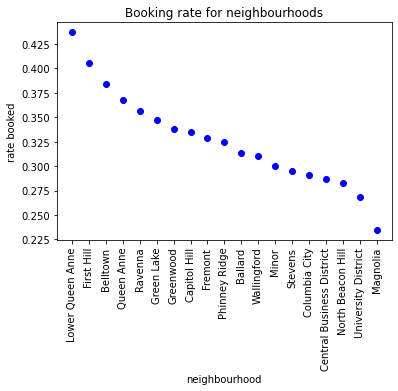

In [293]:
# plot availability, easier to see if we sort the data descending
plt.plot(neighbourhood_final[neighbourhood_final['count']>50].booked.sort_values(ascending=False), 'ob')
plt.xticks(rotation=90)
plt.title('Booking rate for neighbourhoods')
plt.ylabel('rate booked')
plt.xlabel('neighbourhood')
plt.show()

## Question 2: What factors are most important for the listing price?

We run a linear regression model for predicting the listing price and have a look which factors have the biggest influence to the listing price.

In [215]:
# we have a look at numeric columns
df_listings.select_dtypes(['int64', 'float64', 'uint8']).columns
#df_listings.info()

Index(['id', 'scrape_id', 'host_id', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'cleaning_fee',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month',
       'Entire home/apt', 'Private room', 'Shared room'],
      dtype='object')

<AxesSubplot:>

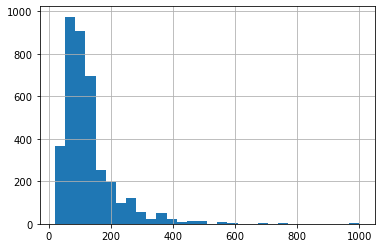

In [299]:
# overview how the price is distributed
df_listings.price.hist(bins=30)

Since we can only use numeric columns for a linear regression model, we have a look at those. First of all we see that not every variable makes sense. We drop all columns including some sort of id. Also longitude and latitude are not useful in this setup.

In [222]:
# for feature matrix also drop price, since this is our traget
df_price_features = df_listings.select_dtypes(['int64', 'float64', 'uint8']).drop(['id', 'scrape_id', 'host_id', 'latitude', 'longitude', 'price'], axis=1)
target_price = df_listings.price

In [225]:
# fit the linear regression model and add a constant to the feature matrix for the intercept
reg = LinearRegression()
X = sm.add_constant(df_price_features)
est = sm.OLS(target_price, X)

est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     177.8
Date:                Mon, 29 Aug 2022   Prob (F-statistic):               0.00
Time:                        11:13:08   Log-Likelihood:                -21006.
No. Observations:                3818   AIC:                         4.207e+04
Df Residuals:                    3789   BIC:                         4.225e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

The R-squared of the model is not very high and we also have some problems with collinearity. We print the correlation matrix and see how we could reduce the feature matrix further. We also drop some of the variables with a very high p-value (>.05)

<AxesSubplot:>

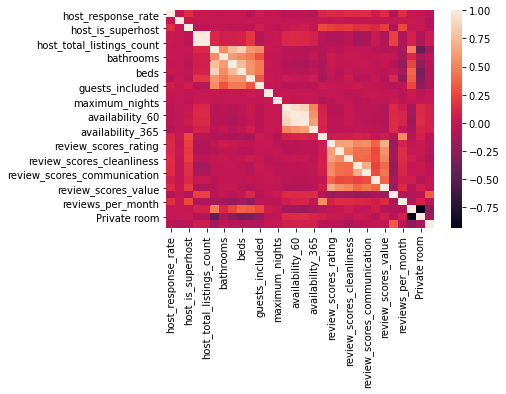

In [230]:
# have a look at the correlation matrix
sns.heatmap(df_price_features.corr())
#print(df_price_features.corr())

Availability and review variables show high correlation. Therefore we might just pick one of them. Also private and shared room are just the opposite of each other, so we might drop one of them. 

In [274]:
# new feature matrix
df_price_features_mod = df_price_features[['host_is_superhost', 'accommodates', 'bathrooms', 'bedrooms', 'cleaning_fee', 'guests_included', 'number_of_reviews', 'review_scores_value', 'reviews_per_month', 'Shared room']]
df_price_features_mod.head()

,host_is_superhost,accommodates,bathrooms,bedrooms,cleaning_fee,guests_included,number_of_reviews,review_scores_value,reviews_per_month,Shared room
0,0.0,4,1.0,1.0,61.710904,2,207,10.000000,4.070000,0
1,1.0,4,1.0,1.0,40.000000,1,43,10.000000,1.480000,0
2,0.0,11,4.5,5.0,300.000000,10,20,10.000000,1.150000,0
3,0.0,3,1.0,0.0,61.710904,1,0,9.452245,2.078919,0
4,0.0,6,2.0,3.0,125.000000,6,38,9.000000,0.890000,0


In [255]:
# fit the linear regression model again
reg = LinearRegression()
Xmod = sm.add_constant(df_price_features_mod)
estmod = sm.OLS(target_price, Xmod)

estmod2 = estmod.fit()
print(estmod2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     430.3
Date:                Mon, 29 Aug 2022   Prob (F-statistic):               0.00
Time:                        13:39:00   Log-Likelihood:                -21164.
No. Observations:                3818   AIC:                         4.235e+04
Df Residuals:                    3807   BIC:                         4.242e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  22.2871    

In [240]:
# drop review_scores_value, since it has a very high p-value
df_price_features_mod_2 = df_price_features_mod.drop(['review_scores_value'], axis=1)

In [256]:
# fit the linear regression model again
reg = LinearRegression()
Xmod = sm.add_constant(df_price_features_mod_2)
estmod = sm.OLS(target_price, Xmod)

estmod2 = estmod.fit()
print(estmod2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     478.1
Date:                Mon, 29 Aug 2022   Prob (F-statistic):               0.00
Time:                        13:41:00   Log-Likelihood:                -21165.
No. Observations:                3818   AIC:                         4.235e+04
Df Residuals:                    3808   BIC:                         4.241e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.8853      3.05

In [297]:
pd.DataFrame(estmod2.params)

,0
const,8.885301
host_is_superhost,8.976056
accommodates,11.975860
bathrooms,20.923778
bedrooms,17.289195
cleaning_fee,0.496479
guests_included,3.654327
number_of_reviews,-0.078917
reviews_per_month,-2.603525
Shared room,-45.565840


Now, our model looks better. R-squared didn't decrease a lot and all variables have small p-value. 
The coefficiant with the highest value is Shared room. Since it has a negative value we can say that if the room is shared it has the most negative influence. This makes sense because in other words we can say, if the room is shared, the home is chaper.
Also the most positive variables make sense. If the number of bedrooms an bathrooms is higher then the home gets more expensive. For sure more bathrooms and bedrooms indicate more space and will therefore be more expensive.

In [246]:
df_price_features_mod_2.describe()

,host_is_superhost,accommodates,bathrooms,bedrooms,cleaning_fee,guests_included,number_of_reviews,reviews_per_month,Shared room
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,0.203772,3.349398,1.259469,1.307712,61.710904,1.672603,22.223415,2.078919,0.030644
std,0.402854,1.977599,0.589130,0.882700,41.725079,1.311040,37.730892,1.665964,0.172375
min,0.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.020000,0.000000
25%,0.000000,2.000000,1.000000,1.000000,35.000000,1.000000,2.000000,0.830000,0.000000
50%,0.000000,3.000000,1.000000,1.000000,61.710904,1.000000,9.000000,2.000000,0.000000
75%,0.000000,4.000000,1.000000,2.000000,65.000000,2.000000,26.000000,2.660000,0.000000
max,1.000000,16.000000,8.000000,7.000000,300.000000,15.000000,474.000000,12.150000,1.000000


## Question 3: Can we predict the rating?

Again we try to run a linear regression model to predict the rating of an airbnb home. This time we split the data into training and test data and evaluate our model.
Since we can only use numeric columns for a linear regression model, we have a look at those. First of all we see that not every variable makes sense. We drop all columns including some sort of id. Also the review_scores_value is a combination of the other reviews, so they are highly correlated. If we run a model with those variables, they will be for sure the most important, so we may also drop them.

<AxesSubplot:>

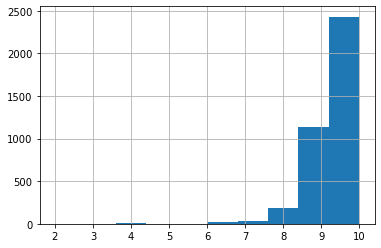

In [300]:
# distribution of the ratings
df_price_features.review_scores_value.hist()

In [251]:
# again we drop columns like ids and also the target variable
X = df_listings.select_dtypes(['int64', 'float64', 'uint8']).drop(['id', 'scrape_id', 'host_id', 'latitude', 'longitude', 'review_scores_value'], axis=1)
y = df_price_features.review_scores_value

In [253]:
# drop the other review columns
X = X.drop(['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location'], axis=1)

In [301]:
# fit the linear regression 
reg = LinearRegression()
Xmod = sm.add_constant(X)
estmod = sm.OLS(y, Xmod)

estmod2 = estmod.fit()
print(estmod2.summary())

                             OLS Regression Results                            
Dep. Variable:     review_scores_value   R-squared:                       0.106
Model:                             OLS   Adj. R-squared:                  0.101
Method:                  Least Squares   F-statistic:                     20.48
Date:                 Tue, 30 Aug 2022   Prob (F-statistic):           1.12e-76
Time:                         11:12:04   Log-Likelihood:                -3745.8
No. Observations:                 3818   AIC:                             7538.
Df Residuals:                     3795   BIC:                             7681.
Df Model:                           22                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
co

This does not look good. Before testing this model, we should further modify. Select only the features with small p-value.

In [303]:
X_modified = X[['host_response_rate', 'host_is_superhost', 'host_listings_count', 'accommodates', 'bedrooms', 'number_of_reviews',
              'calculated_host_listings_count', 'reviews_per_month', 'Entire home/apt', 'Private room', 'Shared room']]

In [304]:
# fit the linear regression 
reg = LinearRegression()
Xmod = sm.add_constant(X_modified)
estmod = sm.OLS(y, Xmod)

estmod2 = estmod.fit()
print(estmod2.summary())

                             OLS Regression Results                            
Dep. Variable:     review_scores_value   R-squared:                       0.099
Model:                             OLS   Adj. R-squared:                  0.097
Method:                  Least Squares   F-statistic:                     41.85
Date:                 Tue, 30 Aug 2022   Prob (F-statistic):           3.25e-79
Time:                         11:18:27   Log-Likelihood:                -3760.9
No. Observations:                 3818   AIC:                             7544.
Df Residuals:                     3807   BIC:                             7612.
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
co

We got a bit worse in terms of r-squared. Nevertheless we try to split our data into training and test data to test the accuracy of our model.

In [307]:
# import necassary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# split data into train and test data and add constant
X_const = sm.add_constant(X_modified)
X_train, X_test, y_train, y_test = train_test_split(X_const, y, test_size = .30, random_state=42)

lm_model = LinearRegression(normalize=True) # Here we normalize our data
lm_model.fit(X_train, y_train)

# we use the fitted model to predict the ratings on our test dataset
y_test_preds = lm_model.predict(X_test)

# we print the 2 most common metrics for linear models, the r-squared and the mean squared error to measure the quality of our model
print('The r-squared obtained on the test set is {}'.format(r2_score(y_test, y_test_preds))) 
print(mean_squared_error(y_test, y_test_preds)) 


The r-squared obtained on the test set is 0.055691274728483786
0.4351005517514503


R-squared from 5.5% is not very high, although the mean squared error looks quite ok. Maybe it words better using a decision tree.

In [306]:
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

y_test_preds = regressor.predict(X_test)

print(r2_score(y_test, y_test_preds)) 
print(mean_squared_error(y_test, y_test_preds)) 

-0.7774127637749733
0.8189623303397937


Not really, we even got a negative mean squared error. Maybe the rating is just not easy to predict with the given variables and we should ask for another question.

## Is a more expensive home rated better?

<AxesSubplot:xlabel='price', ylabel='review_scores_value'>

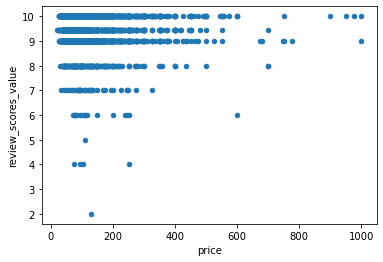

In [316]:
df_listings[['price', 'review_scores_value']].plot.scatter(x='price', y = 'review_scores_value')